In [72]:
import inspect
import json
import os
import time
import numpy as np
from functools import wraps
import pandas as pd
import seaborn as sns
import random

Platform class

In [56]:
class Platform:
    def __init__(self, algorithm, processing, table_path):
        self.algorithm = algorithm
        self.processing = processing
        self.table_path = table_path
        self.logs = False

        self.benchmark = {"name" : type(self.algorithm).__name__}
        self.benchmark = {"table_path": table_path}

    def start(self, run_type="test", logs=False):
        self.logs = logs

        if self.logs:
            if isinstance(self.algorithm, LosslessCompressionAlgorithm):
                self.benchmark["isLossLess"] = True
            else:
                self.benchmark["isLossLess"] = False

            if isinstance(self.algorithm, LearningCompressionAlgorithm):
                self.benchmark["isLearning"] = True
            else:
                self.benchmark["isLearning"] = False


        if run_type == 'test':
            self.test()
        elif run_type == 'compress':
            self.preprocess_and_compress()
        elif run_type == 'decompress':
            self.decompress_and_postprocess()

    def measure_time(flag):
        def decorator(func):
            def wrapper(self, *args, **kwargs):
                start_time = time.time()
                result = func(self, *args, **kwargs)
                end_time = time.time()

                if getattr(self, flag):
                    print(f"Function {func.__name__} took {end_time - start_time} seconds to execute.")
                    self.benchmark[func.__name__ + "_time"] = end_time - start_time

                return result
            return wrapper
        return decorator

    @measure_time("logs")
    def preprocess_and_compress(self):
        preprocessed_table = self.processing.do_preprocess(self.table_path)
        compressed_table = self.algorithm.compress(preprocessed_table)
        if self.logs:
            compression_rate = self.get_compression_rate(compressed_table)
            self.benchmark["compression_rate"] = compression_rate
        return compressed_table

    @measure_time("logs")
    def decompress_and_postprocess(self, compressed_table):
        decompressed_table = self.algorithm.decompress(compressed_table)
        table = self.processing.do_postprocess(decompressed_table)

        if self.logs:
            loss_rate = self.get_loss_rate(table)
            self.benchmark["loss_rate"] = loss_rate

        return table

    @measure_time("logs")
    def test(self):
        compressed_data = self.preprocess_and_compress()
        decompressed_data = self.decompress_and_postprocess(compressed_data)

    def get_compression_rate(self, compressed_table): #I'm assuming compressed_table is actually bytes-like
        with open(self.table_path) as f:
            f.seek(0, os.SEEK_END)
            return f.tell() / len(compressed_table)

    def get_loss_rate(self, table):
        print("I am dummy: ", inspect.currentframe().f_code.co_name)
        return random.randint(0, 20)



In [76]:
def json_platform(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)

    platform = Platform(globals()[config["Algorithm"]](), globals()[config["Processing"]](), config["table_path"])
    platform.start(config["run_type"], config["logs"])

json_platform("plug_config.json")

I am dummy compression
I am dummy:  get_compression_rate
Function preprocess_and_compress took 2.0002260208129883 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.0121607780456543 seconds to execute.
Function test took 3.0123867988586426 seconds to execute.


Compression Algorithm Classes

In [34]:
import abc

class CompressionAlgorithm(abc.ABC):
    def __init__(self):
        ...
    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def compress(self, table):
        ...

    @abc.abstractmethod
    def decompress(self, compressed_data):
        ...

class LearningCompressionAlgorithm(CompressionAlgorithm):

    @abc.abstractmethod
    def fit(self, training_data):
        ...

class NonLearningCompressionAlgorithm(CompressionAlgorithm):
    ...

class LosslessCompressionAlgorithm(CompressionAlgorithm):
    ...

class LossyCompressionAlgorithm(CompressionAlgorithm):
    ...

In [54]:
class DummyCompressionAlgorithm(LosslessCompressionAlgorithm, LearningCompressionAlgorithm):
    name = 'Dummy Compression Algorithm'
    def compress(self, table):
        time.sleep(2)
        print("I am dummy compression")
        return table
    def decompress(self, compressed_data):
        time.sleep(1)
        print("I am dummy decompression")
        return compressed_data

    def fit(self, training_data):
        return 0

Processing Classes

In [36]:
class Processing(abc.ABC):
    def __init__(self):
        ...
    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def do_preprocess(self, raw_table):
        ...

    @abc.abstractmethod
    def do_postprocess(self, processed_table):
        ...

In [37]:
class DummyProcessing(Processing):
    name = "Dummy Pre/Post-Processing"
    def do_preprocess(self, raw_table):
        return raw_table
    def do_postprocess(self, processed_table):
        return processed_table


Testing

In [57]:
benchmarks = []
Algos = [DummyCompressionAlgorithm(), DummyCompressionAlgorithm(), DummyCompressionAlgorithm()]
Processes = [DummyProcessing(), DummyProcessing()]
for algo in Algos:
    for proc in Processes:
        a = Platform(algo, proc, "asad/acap/asa.csv")
        a.start("test", logs=True)
        print(a.benchmark)
        benchmarks.append(a.benchmark)
        print("---------------------")

I am dummy compression
I am dummy:  get_compression_rate
Function preprocess_and_compress took 2.0092406272888184 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.0151996612548828 seconds to execute.
Function test took 3.024440288543701 seconds to execute.
{'table_path': 'asad/acap/asa.csv', 'isLossLess': True, 'isLearning': True, 'compression_rate': 30, 'preprocess_and_compress_time': 2.0092406272888184, 'loss_rate': 19, 'decompress_and_postprocess_time': 1.0151996612548828, 'test_time': 3.024440288543701}
---------------------
I am dummy compression
I am dummy:  get_compression_rate
Function preprocess_and_compress took 2.0153441429138184 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.0102825164794922 seconds to execute.
Function test took 3.0256266593933105 seconds to execute.
{'table_path': 'asad/acap/asa.csv', 'isLossLess': True, 'isLearning': True,

In [ ]:
#1. replace json with arguments of the class | DONE
#2. do not keep table in class instance | DONE
#3. change names of the Platform to more relevant | DONE
#4. rename compression to compress | DONE
#5. add ability to not compress tables every time Platform being created | I can just pass already preprocessed table to Platform
#and also pass the flush preprocessing class which do nothing

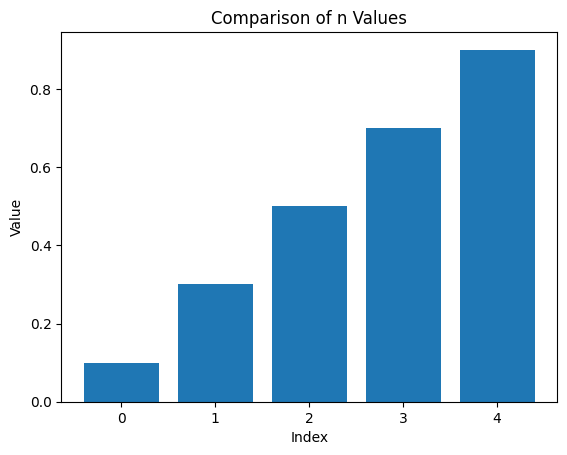

In [61]:
import matplotlib.pyplot as plt

def plot_graphics(n_values):
    plt.bar(range(len(n_values)), n_values)
    plt.title('Comparison of n Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


In [97]:
import seaborn as sns
import pandas as pd

def plot_benchmarks(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.barplot(x='index', y=column_name, data=df)

def plot_scatter(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.scatterplot(x='index', y=column_name, data=df)

def plot_hist(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.histplot(x='index', y=column_name, data=df)



19
3
12
19
6
6


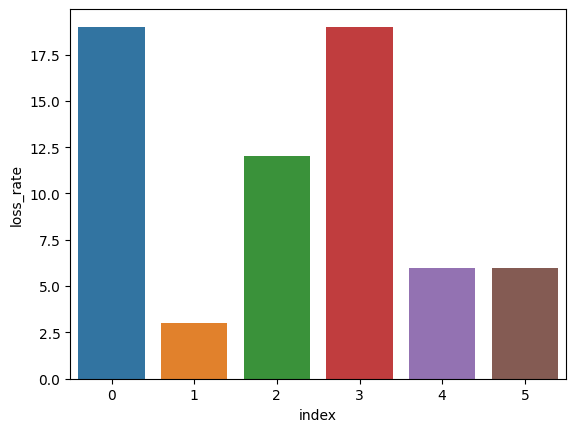

In [102]:
plot_benchmarks(benchmarks, "loss_rate")
for i in benchmarks:
    print(i["loss_rate"])

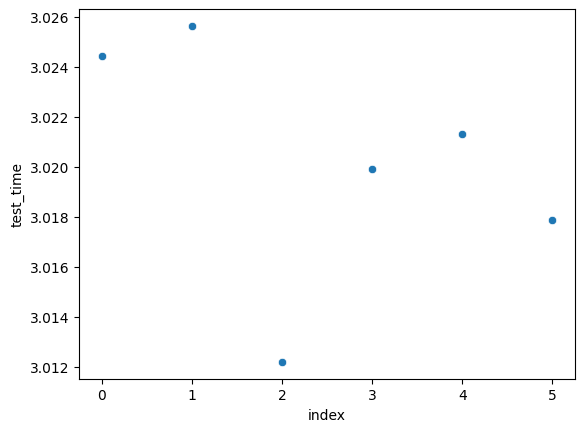

In [93]:
plot_scatter(benchmarks, "test_time")

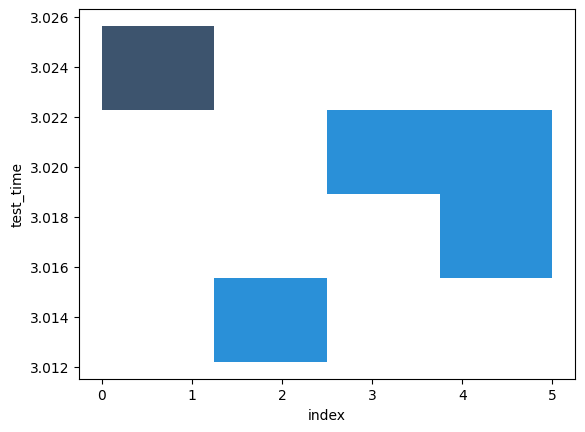

In [98]:
plot_hist(benchmarks, "test_time")